1. Rank comparisons
    - scatterplot
    - delta rank distribution 
2. Correlation between models
    - spearman or kendall correlation between rankings
    - agreemnt in top k
3. Error case analysis
    - identify systematic weaknesses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

import pandas as pd
from scipy.stats import spearmanr, kendalltau, pearsonr
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm


In [2]:
import seaborn as sns
palette = ["#E21B49", "#C18F1C", "#06D6A0", "#77D3F1", "#041C24"]
sns.set_theme(style="white", palette=palette)

# Load data

In [3]:
FLARE_pth = "/data/yzhouc01/FILIP-MS/experiments/20250930_optimized_flare_42/main_result/result_MassSpecGym_retrieval_candidates_formula.pkl"
jestr_pth = "/data/yzhouc01/JESTR1/experiments/20251002_msgym/result_MassSpecGym_retrieval_candidates_formula.pkl"

with open(FLARE_pth, "rb") as f:
    flare_results = pickle.load(f)
with open(jestr_pth, "rb") as f:
    jestr_results = pickle.load(f)

In [4]:
def get_target(candidates, labels):
    return np.array(candidates)[labels].item()

flare_results['target'] = flare_results.apply(lambda x: get_target(x['candidates'], x['labels']), axis=1)
jestr_results['target'] = jestr_results.apply(lambda x: get_target(x['candidates'], x['labels']), axis=1)

## Rank comparions

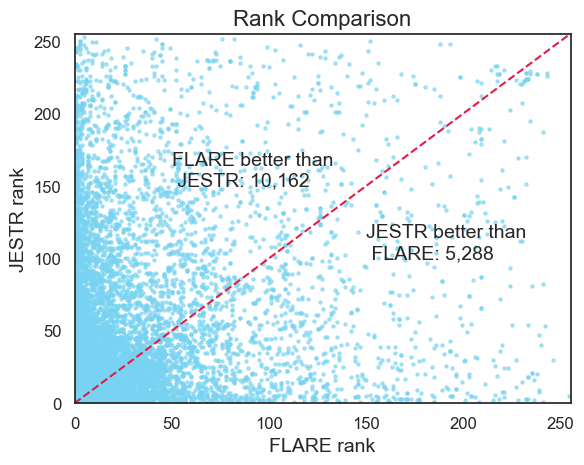

In [38]:
# average rank comparison, group by target molecule
# flare_rank = flare_results[['target', 'rank']].groupby('target').agg({'rank': 'mean'})['rank']
# jestr_rank = jestr_results[['target', 'rank']].groupby('target').agg({'rank': 'mean'})['rank']

flare_rank = flare_results['rank']
jestr_rank = jestr_results['rank']

# plot scatterplot
plt.scatter(flare_rank, jestr_rank, alpha=0.6, s=5, color=palette[3], )

# add 1-1 line
plt.plot([0, 255], [0, 255], color=palette[0], linestyle='--')

# show number of points above and below the 1-1 line
num_above = sum(flare_rank > jestr_rank)
num_below = sum(flare_rank < jestr_rank)

# add text to the plot
plt.text(150, 100, f'JESTR better than \n FLARE: {num_above:,}', fontsize=14)
plt.text(50, 150, f'FLARE better than \n JESTR: {num_below:,}', fontsize=14)

plt.xlabel('FLARE rank', fontdict={'size': 14})
plt.ylabel('JESTR rank', fontdict={'size': 14})
plt.title('Rank Comparison', fontdict={'size': 16} )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.show()

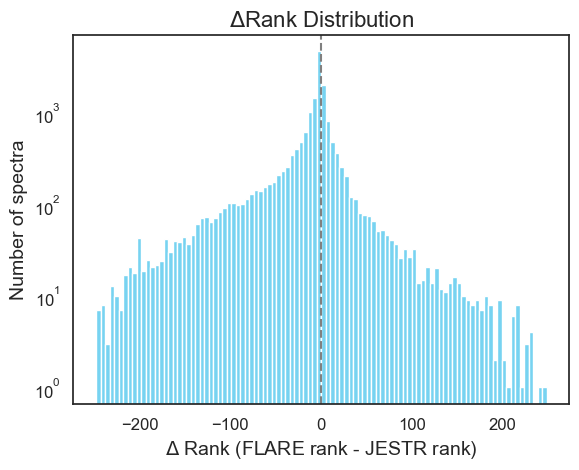

In [5]:
# delta rank distribution

# flare_rank = flare_results[['target', 'rank']].groupby('target').agg({'rank': 'mean'})['rank']
# jestr_rank = jestr_results[['target', 'rank']].groupby('target').agg({'rank': 'mean'})['rank']
flare_rank = flare_results['rank']
jestr_rank = jestr_results['rank']

delta_rank = flare_rank - jestr_rank

plt.hist(delta_rank, color=palette[3], bins=100, log=True)

# add line at 0
plt.axvline(x=0, color='gray', linestyle='--')

# add text to the plot
# plt.text(150, 1000, f'JESTR better than \n FLARE', fontsize=14)
# plt.text(-220, 1000, f'FLARE better than \n JESTR', fontsize=14)

plt.xlabel('$\Delta$ Rank (FLARE rank - JESTR rank)', fontdict={'size': 14})
plt.ylabel('Number of spectra', fontdict={'size': 14})
plt.title('$\Delta$Rank Distribution', fontdict={'size': 16})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Correlation
    - spearman or kendall correlation between rankings
    - agreemnt in top k

In [26]:
from tqdm import tqdm

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, kendalltau, pearsonr

# ------------------------
# Expand lists into long format
# ------------------------
def expand_results(df):
    """
    Expand a dataframe with columns:
        identifier | candidates (list) | scores (list)
    into a long format:
        identifier | candidate | score | rank
    where rank is assigned by sorting scores (descending).
    """
    rows = []
    for _, row in df.iterrows():
        identifier = row['identifier']
        candidates = row['candidates']
        scores = row['scores']

        # rank candidates by score (1 = best)
        order = np.argsort(scores)[::-1]  # descending
        for r, idx in enumerate(order, start=1):
            rows.append({
                "identifier": identifier,
                "candidate": candidates[idx],
                "score": scores[idx],
                "rank": r
            })
    return pd.DataFrame(rows)


# ------------------------
# Alignment + correlations
# ------------------------
def align_candidates(dfA, dfB):
    """
    Align expanded results from two models on identifier + candidate.
    """
    merged = pd.merge(
        dfA[['identifier','candidate','score','rank']],
        dfB[['identifier','candidate','score','rank']],
        on=['identifier','candidate'],
        suffixes=('_A','_B')
    )
    return merged


# ------------------------
# rank correlation per spectrum
# ------------------------
def _compute_correlations_for_identifier(identifier, rankA, rankB, scoreA, scoreB):
    if len(rankA) < 2:
        return None
    rho, _ = spearmanr(rankA, rankB)
    tau, _ = kendalltau(rankA, rankB)
    r, _ = pearsonr(scoreA, scoreB)
    return {"identifier": identifier, "spearman": rho, "kendall": tau, "pearson": r}

def compute_within_spectrum_correlations_parallel(merged, n_jobs=None):
    print("Computing within spectrum correlations (parallelized)")

    grouped = merged.groupby('identifier', sort=False)
    tasks = [
        (identifier, sub['rank_A'].values, sub['rank_B'].values, sub['score_A'].values, sub['score_B'].values)
        for identifier, sub in grouped
    ]

    results = []
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        futures = [executor.submit(_compute_correlations_for_identifier, *t) for t in tasks]
        for future in tqdm(as_completed(futures), total=len(futures)):
            res = future.result()
            if res is not None:
                results.append(res)

    return pd.DataFrame(results)


# ------------------------
# jarccard for topk
# ------------------------
def _compute_jaccard_for_identifier(identifier, candidates, rankA, rankB, k):
    if len(candidates) == 0:
        return None

    # Sort locally using NumPy argsort (faster than pandas sort_values)
    idxA = np.argsort(rankA)[:k]
    idxB = np.argsort(rankB)[:k]
    topA = set(candidates[idxA])
    topB = set(candidates[idxB])

    union = topA | topB
    jaccard = len(topA & topB) / len(union) if union else np.nan

    return {"identifier": identifier, f"jaccard@{k}": jaccard}

def compute_topk_jaccard_parallel(merged, k=10, n_jobs=None):
    """
    Compute Jaccard overlap of top-k candidate sets from both models in parallel.
    """
    print(f"Computing top-{k} Jaccard overlaps (parallelized)")

    grouped = merged.groupby('identifier', sort=False)
    tasks = [
        (identifier, sub['candidate'].values, sub['rank_A'].values, sub['rank_B'].values, k)
        for identifier, sub in grouped
    ]

    results = []
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        futures = [executor.submit(_compute_jaccard_for_identifier, *t) for t in tasks]
        for future in tqdm(as_completed(futures), total=len(futures)):
            res = future.result()
            if res is not None:
                results.append(res)

    return pd.DataFrame(results)



In [25]:
# Expand results (identifier, candidate, score_A, rank_A, score_B, rank_B)
# A = flare, B = JESTR

longA = expand_results(flare_results)
longB = expand_results(jestr_results)

merged = align_candidates(longA, longB)

In [27]:
# Compute within-spectrum correlations (36 minutes)
within_correlations = compute_within_spectrum_correlations_parallel(merged, n_jobs=50)


Computing within spectrum correlations (parallelized)


100%|██████████| 17556/17556 [00:02<00:00, 6185.70it/s]


In [23]:
within_correlations.head()

identifier  spearman   kendall   pearson
0  MassSpecGymID0000203 -0.066667 -0.058462 -0.056994
1  MassSpecGymID0000201 -0.182222 -0.101538 -0.338821
2  MassSpecGymID0000204 -0.461197 -0.316923 -0.536110
3  MassSpecGymID0000205 -0.301880 -0.175385 -0.290422
4  MassSpecGymID0000202 -0.430427 -0.304615 -0.474249

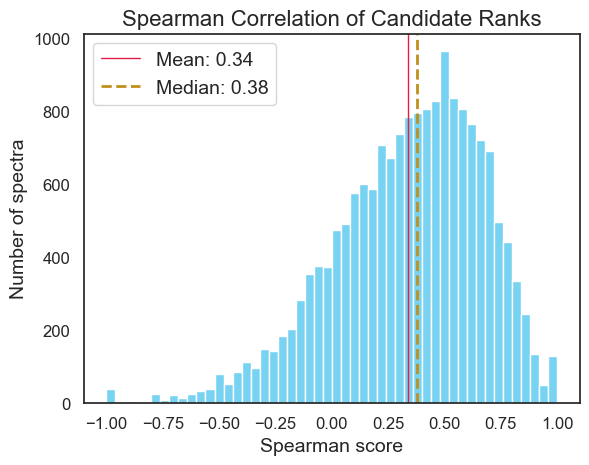

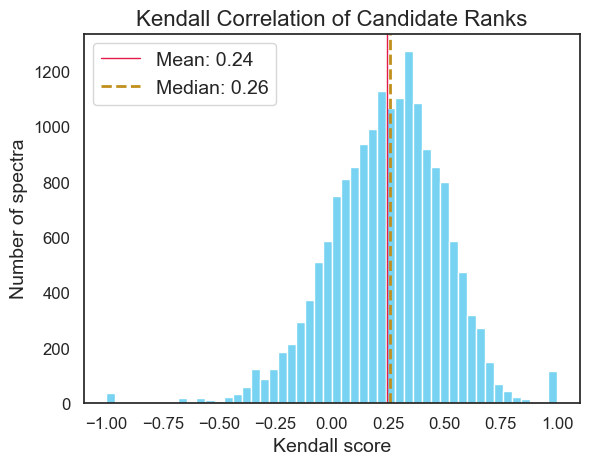

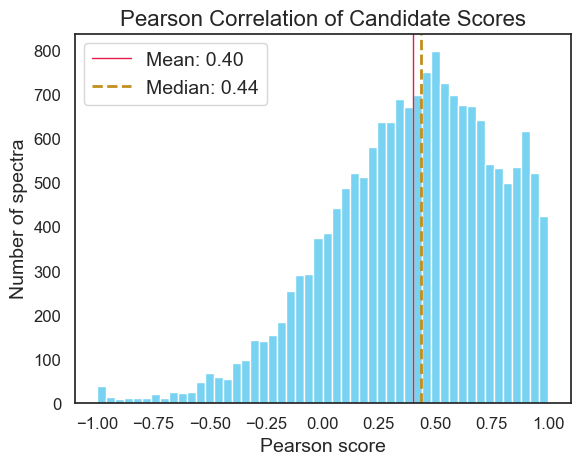

In [52]:
mean_color = palette[0]
median_color = palette[1]
bar_color = palette[3]

# Distribution of spearman correlation
spearman_scores = within_correlations['spearman']
plt.hist(spearman_scores, color=bar_color, bins=50)
plt.axvline(np.mean(spearman_scores), color=mean_color, linestyle='-', linewidth=1, label=f'Mean: {np.mean(spearman_scores):.2f}')
plt.axvline(np.median(spearman_scores), color=median_color, linestyle='dashed', linewidth=2, label=f'Median: {np.median(spearman_scores):.2f}')
plt.title("Spearman Correlation of Candidate Ranks", fontdict={'size': 16})
plt.xlabel("Spearman score", fontdict={'size': 14})
plt.ylabel("Number of spectra", fontdict={'size': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

# Distribution of kendall correlation
kendall_scores = within_correlations['kendall']
plt.hist(kendall_scores, color=bar_color, bins=50)
plt.axvline(np.mean(kendall_scores), color=mean_color, linestyle='-', linewidth=1, label=f'Mean: {np.mean(kendall_scores):.2f}')
plt.axvline(np.median(kendall_scores), color=median_color, linestyle='dashed', linewidth=2, label=f'Median: {np.median(kendall_scores):.2f}')
plt.title("Kendall Correlation of Candidate Ranks", fontdict={'size': 16})
plt.xlabel("Kendall score", fontdict={'size': 14})
plt.ylabel("Number of spectra", fontdict={'size': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

# Distribution of pearson correlation
pearson_scores = within_correlations['pearson']
plt.hist(pearson_scores, color=bar_color, bins=50)
plt.axvline(np.mean(pearson_scores), color=mean_color, linestyle='-', linewidth=1, label=f'Mean: {np.mean(pearson_scores):.2f}')
plt.axvline(np.median(pearson_scores), color=median_color, linestyle='dashed', linewidth=2, label=f'Median: {np.median(pearson_scores):.2f}')
plt.title("Pearson Correlation of Candidate Scores", fontdict={'size': 16})
plt.xlabel("Pearson score", fontdict={'size': 14})
plt.ylabel("Number of spectra", fontdict={'size': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()


In [42]:
# 36 minutes
jaccard = compute_topk_jaccard_parallel(merged, k=10, n_jobs=50)

Computing top-10 Jaccard overlaps (parallelized)


100%|██████████| 17556/17556 [00:02<00:00, 6514.95it/s]


In [ ]:
jaccard.head(3)

identifier  jaccard@10
0  MassSpecGymID0000201    0.176471
1  MassSpecGymID0000202    0.111111
2  MassSpecGymID0000203    0.176471

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


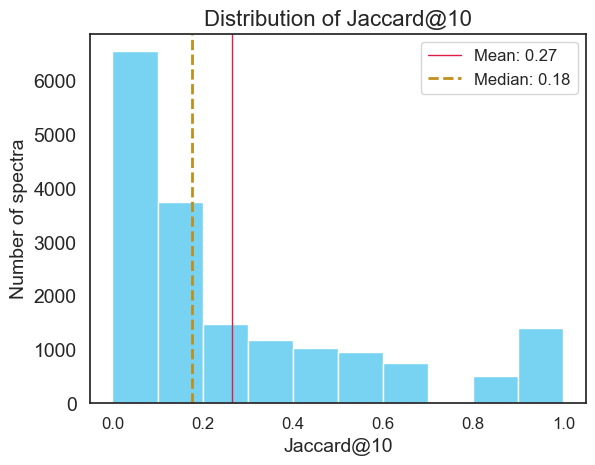

In [53]:
# Distribution of pearson correlation
jarccard_scores = jaccard['jaccard@10']
plt.hist(jarccard_scores, color=bar_color)
plt.axvline(np.mean(jarccard_scores), color=mean_color, linestyle='-', linewidth=1, label=f'Mean: {np.mean(jarccard_scores):.2f}')
plt.axvline(np.median(jarccard_scores), color=median_color, linestyle='dashed', linewidth=2, label=f'Median: {np.median(jarccard_scores):.2f}')
plt.title("Distribution of Jaccard@10", fontdict={'size': 16})
plt.xlabel("Jaccard@10", fontdict={'size': 14})
plt.ylabel("Number of spectra", fontdict={'size': 14})
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.show()

## Target-Cand Separation

In [32]:
def get_target_score(scores, labels):
    return scores[labels][0]

def get_avg_cand_scores(scores, labels):
    return np.mean(np.array(scores)[~np.array(labels)])

def get_best_cand_score(scores, labels):
    try:
        return np.max(np.array(scores)[~np.array(labels)])
    except ValueError:
        return np.nan

In [ ]:
flare_results['target_score'] = flare_results.apply(lambda x: get_target(x['scores'], x['labels']), axis=1)
flare_results['avg_cand_score'] = flare_results.apply(lambda x: get_avg_cand_scores(x['scores'], x['labels']), axis=1)
flare_results['best_cand_score'] = flare_results.apply(lambda x: get_best_cand_score(x['scores'], x['labels']), axis=1)

jestr_results['target_score'] = jestr_results.apply(lambda x: get_target(x['scores'], x['labels']), axis=1)
jestr_results['avg_cand_score'] = jestr_results.apply(lambda x: get_avg_cand_scores(x['scores'], x['labels']), axis=1)
jestr_results['best_cand_score'] = jestr_results.apply(lambda x: get_best_cand_score(x['scores'], x['labels']), axis=1)


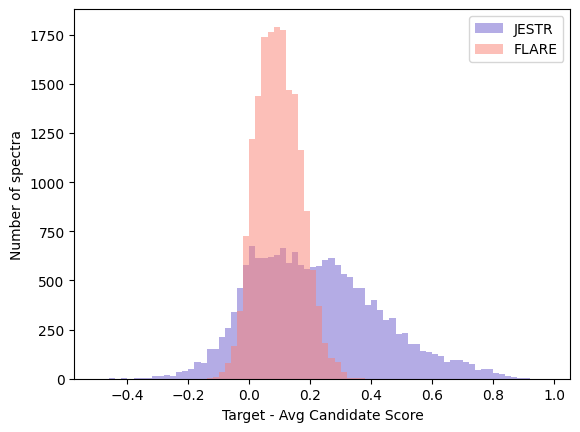

In [24]:
# Distribution of target-cand score 

jestr_diff = jestr_results['target_score']-jestr_results['avg_cand_score']
plt.hist(jestr_diff, color='slateblue', alpha=0.5, bins=np.arange(-0.5, 1, 0.02), label='JESTR')

flare_diff = flare_results['target_score']-flare_results['avg_cand_score']
plt.hist(flare_diff, color='salmon', alpha=0.5, bins=np.arange(-0.5, 1, 0.02), label= 'FLARE')

plt.xlabel("Target - Avg Candidate Score")
plt.ylabel("Number of spectra")
plt.legend()
plt.show()





## Meta Analysis

In [55]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd
import numpy as np

# ----------------------------
# Individual feature functions
# ----------------------------

def mol_from_smiles(smiles):
    """Safely parse SMILES into RDKit molecule."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        Chem.SanitizeMol(mol)
        return mol
    except:
        return None


def compute_mol_weight(mol):
    return Descriptors.MolWt(mol) if mol else np.nan


def compute_heavy_atom_count(mol):
    return mol.GetNumHeavyAtoms() if mol else np.nan


def compute_rotatable_bonds(mol):
    return Descriptors.NumRotatableBonds(mol) if mol else np.nan


def compute_ring_count(mol):
    return rdMolDescriptors.CalcNumRings(mol) if mol else np.nan


def compute_hbond_donors(mol):
    return Descriptors.NumHDonors(mol) if mol else np.nan


def compute_hbond_acceptors(mol):
    return Descriptors.NumHAcceptors(mol) if mol else np.nan


def compute_dbe(mol):
    """Double bond equivalents (Degree of Unsaturation)."""
    if mol is None:
        return None

    c = 0
    h_halogen = 0
    n = 0
    
    # Iterate through all atoms in the molecule to count elements
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol == 'C':
            c += 1
        elif symbol in ['H', 'F', 'Cl', 'Br', 'I']:
            h_halogen += 1
        elif symbol == 'N':
            n += 1
    
    # Apply the DBE formula
    dbe = c - (h_halogen / 2) + (n / 2) + 1
    return dbe


def compute_element_ratios(mol):
    """Compute atomic ratios (O/C, N/C, H/C)."""
    if mol is None:
        return np.nan, np.nan, np.nan
    counts = {a.GetSymbol(): 0 for a in mol.GetAtoms()}
    for atom in mol.GetAtoms():
        counts[atom.GetSymbol()] += 1
    C = counts.get("C", 0)
    H = counts.get("H", 0)
    O = counts.get("O", 0)
    N = counts.get("N", 0)
    if C == 0:
        return np.nan, np.nan, np.nan
    return O / C, N / C, H / C


def compute_topological_features(mol):
    """Simple topological features: graph diameter and avg degree."""
    if mol is None:
        return np.nan, np.nan
    G = Chem.rdmolops.GetAdjacencyMatrix(mol)
    degrees = G.sum(axis=1)
    avg_degree = degrees.mean()
    # approximate diameter via longest shortest path
    from scipy.sparse.csgraph import shortest_path
    dist = shortest_path(G)
    diameter = np.nanmax(dist)
    return avg_degree, diameter


# ----------------------------
# Master feature extraction
# ----------------------------

def compute_molecule_metadata(df, smiles_col='target'):
    """Compute molecular descriptors for each SMILES in a DataFrame."""
    features = []
    for i, smiles in enumerate(df[smiles_col]):
        mol = mol_from_smiles(smiles)
        mw = compute_mol_weight(mol)
        heavy = compute_heavy_atom_count(mol)
        rot = compute_rotatable_bonds(mol)
        rings = compute_ring_count(mol)
        donors = compute_hbond_donors(mol)
        acceptors = compute_hbond_acceptors(mol)
        dbe = compute_dbe(mol)
        o_c, n_c, h_c = compute_element_ratios(mol)
        avg_deg, diam = compute_topological_features(mol)

        features.append({
            "MolWt": mw,
            "HeavyAtoms": heavy,
            "RotBonds": rot,
            "Rings": rings,
            "HBDonors": donors,
            "HBAcceptors": acceptors,
            "DBE": dbe,
            "OtoC": o_c,
            "NtoC": n_c,
            "HtoC": h_c,
            "AvgDegree": avg_deg,
            "Diameter": diam
        })

    feature_df = pd.DataFrame(features, index=df.index)
    return pd.concat([df, feature_df], axis=1)


In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# -----------------------------
# 1️⃣ Scatter + trendline plot
# -----------------------------
def plot_trend(df, feature, target='delta_rank', smooth=True):
    """
    Scatter + LOWESS trendline of delta_rank vs a continuous feature.
    """
    plt.figure(figsize=(6,4))
    sns.regplot(
        x=feature, y=target, data=df,
        lowess=smooth, scatter_kws={'alpha':0.4, 's':30}, line_kws={'color':palette[0]}
    )
    plt.axhline(0, color='gray', lw=1, ls='--')
    plt.title(f"{target} vs {feature}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 2️⃣ Boxplot for discrete features
# -----------------------------
def plot_box_trend(df, feature, target='delta_rank', bins=None):
    """
    Boxplot of delta_rank across binned or discrete feature values.
    """
    # plt.figure(figsize=(6,4))
    if bins:
        df['_bin'] = pd.cut(df[feature], bins=bins)
        sns.boxplot(x='_bin', y=target, data=df, color=palette[3])
        plt.xticks(rotation=30, ha='right')
    else:
        sns.boxplot(x=feature, y=target, data=df, color=palette[3])
    plt.axhline(0, color='gray', lw=1, ls='--')
    plt.title(f"{target} by {feature}", fontsize=16)
    plt.tight_layout()
    plt.show()
    if '_bin' in df.columns:
        df.drop(columns='_bin', inplace=True)

# -----------------------------
# 3️⃣ Correlation overview
# -----------------------------
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list("custom_div", [palette[0], "white", palette[3]])

def plot_feature_correlations(df, target='delta_rank', feature_cols=None):
    """
    Heatmap of correlations between delta_rank and numeric molecular features.
    """
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in ['identifier','Target',target] and np.issubdtype(df[c].dtype, np.number)]
    corr = df[feature_cols + [target]].corr()[[target]].sort_values(by=target, ascending=False)
    
    plt.figure(figsize=(3.5, len(corr)*0.4 + 1))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Correlation with {target} ")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4️⃣ Summary multi-feature trend grid
# -----------------------------
def plot_multi_trends(df, features, target='delta_rank'):
    """
    Grid of small trend plots for quick scanning.
    """
    n = len(features)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.5*nrows))
    axes = axes.flatten()
    
    for i, feat in enumerate(features):
        sns.regplot(
            x=feat, y=target, data=df,
            lowess=True, ax=axes[i],
            scatter_kws={'alpha':0.3, 's':15}, line_kws={'color':palette[0]}
        )
        axes[i].axhline(0, color='gray', lw=1, ls='--')
        # axes[i].set_title(feat)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f"{target} Trends Across Molecular Features", fontsize=16)
    fig.tight_layout()
    plt.show()


In [57]:
meta_df = compute_molecule_metadata(flare_results)

In [ ]:
meta_df[''] = meta_df['rank'] - jestr_results['rank']

In [60]:
meta_df['JESTR rank'] = jestr_results['rank']

In [61]:
meta_df.rename(columns={'rank': 'FLARE rank'}, inplace=True)

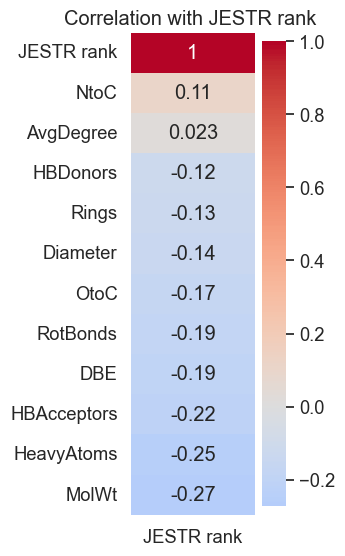

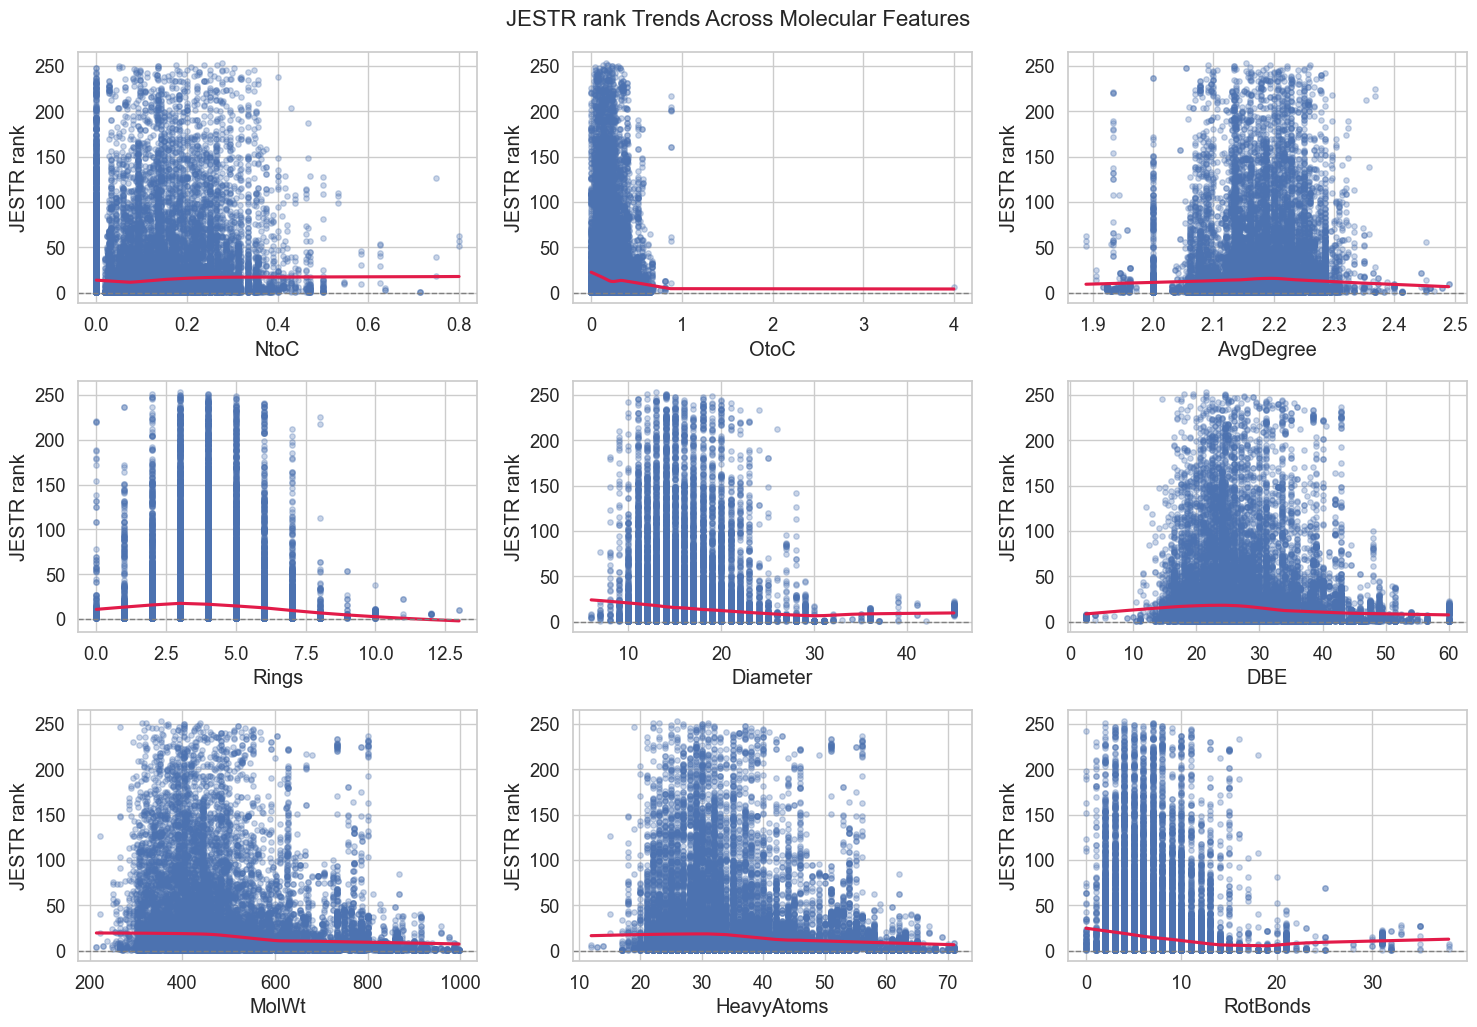

In [73]:
target = 'JESTR rank'
# 1️⃣ Quick correlation overview
plot_feature_correlations(meta_df, target=target, feature_cols=['MolWt', 'HeavyAtoms', 'RotBonds',
       'Rings', 'HBDonors', 'HBAcceptors', 'DBE', 'OtoC', 'NtoC',
       'AvgDegree', 'Diameter'])

# 2️⃣ Continuous variable trends
# plot_trend(meta_df, 'MolWt')
# plot_trend(meta_df, 'RotBonds')
# plot_trend(meta_df, 'OtoC')

# 3️⃣ Box/binned trends
# plot_box_trend(meta_df, 'Rings')
# plot_box_trend(meta_df, 'HeavyAtoms', bins=[0,10,20,30,40,60,100])

# 4️⃣ Multi-trend grid
plot_multi_trends(meta_df, ['NtoC','OtoC','AvgDegree', 'Rings', 'Diameter', 'DBE', 'MolWt', 'HeavyAtoms', 'RotBonds'], target=target)


## Generalizability

In [74]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from tqdm import tqdm

# ----------------------------
# Helper: safe molecule parsing + fingerprint
# ----------------------------
def mol_from_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

def morgan_fp(smiles, radius=2, nbits=2048):
    mol = mol_from_smiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)

# ----------------------------
# Optimized computation
# ----------------------------
def compute_max_similarity_optimized(train_df, test_df, smiles_col='smiles', radius=2, nbits=2048):
    """
    Compute maximum Tanimoto similarity between test and training molecules.
    Optimized to handle repeated SMILES efficiently.
    Adds 'max_train_sim' column to test_df.
    """

    # Unique SMILES for train/test
    unique_train = pd.DataFrame(train_df[smiles_col].unique(), columns=[smiles_col])
    unique_test  = pd.DataFrame(test_df[smiles_col].unique(), columns=[smiles_col])

    print(f"Unique train molecules: {len(unique_train)}")
    print(f"Unique test molecules:  {len(unique_test)}")

    # Compute unique fingerprints
    print("Computing train fingerprints...")
    train_fps = {s: morgan_fp(s, radius, nbits) for s in tqdm(unique_train[smiles_col])}
    print("Computing test fingerprints...")
    test_fps = {s: morgan_fp(s, radius, nbits) for s in tqdm(unique_test[smiles_col])}

    # Compute max similarity for each unique test molecule
    print("Computing similarities (unique pairs)...")
    results = {}
    train_nonnull = [fp for fp in train_fps.values() if fp is not None]
    for s_test, fp_test in tqdm(test_fps.items()):
        if fp_test is None:
            results[s_test] = np.nan
            continue
        sims = DataStructs.BulkTanimotoSimilarity(fp_test, train_nonnull)
        results[s_test] = max(sims) if sims else np.nan

    # Map back to the full test dataframe
    test_df = test_df.copy()
    test_df['max_train_sim'] = test_df[smiles_col].map(results)
    return test_df


In [75]:
data_df = pd.read_csv('/r/hassounlab/spectra_data/msgym/MassSpecGym.tsv', sep='\t')
train_df = data_df[data_df['fold']=='train']
test_df = data_df[data_df['fold']=='test']

In [76]:

test_df = compute_max_similarity_optimized(train_df, test_df)

Unique train molecules: 25046
Unique test molecules:  3170
Computing train fingerprints...


  0%|          | 0/25046 [00:00<?, ?it/s]

[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerator
[21:03:36] DEPRECATION WARNING: please use MorganGenerat

Computing test fingerprints...


  0%|          | 0/3170 [00:00<?, ?it/s][21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRECATION WARNING: please use MorganGenerator
[21:03:41] DEPRE

Computing similarities (unique pairs)...


100%|██████████| 3170/3170 [00:07<00:00, 422.51it/s]


In [77]:
# Merge with your model comparison metadata
meta_df = meta_df.merge(test_df[['identifier','max_train_sim']], on='identifier', how='left')

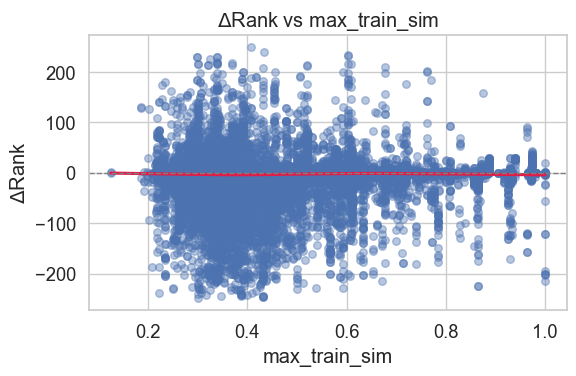

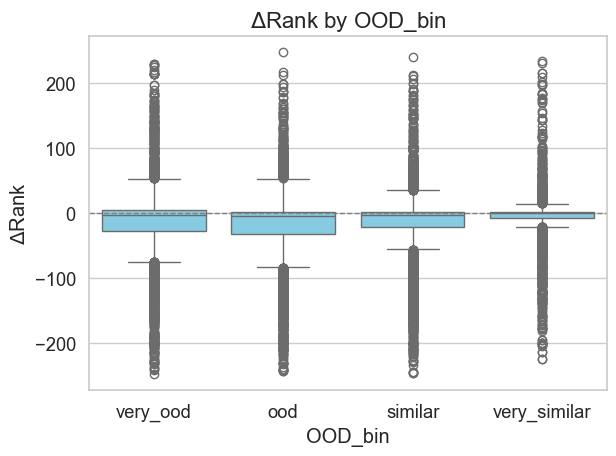

Spearman ρ=0.063, p=7.11e-17


In [82]:


meta_df['$\Delta$Rank'] = meta_df['delta_rank']
target = '$\Delta$Rank'

plot_trend(meta_df, 'max_train_sim', target=target)

meta_df['OOD_bin'] = pd.qcut(meta_df['max_train_sim'], q=4, labels=['very_ood','ood','similar','very_similar'])
plot_box_trend(meta_df, 'OOD_bin', target=target)

# from scipy.stats import spearmanr
rho, p = spearmanr(meta_df['max_train_sim'], meta_df[target])
print(f"Spearman ρ={rho:.3f}, p={p:.3g}")


## Case Analysis

In [26]:
jestr_results[cond2].head()

identifier                                         candidates  \
1082  MassSpecGymID0035491  [COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)...   
1100  MassSpecGymID0037576  [CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=C...   
1170  MassSpecGymID0037651  [CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=C...   
1463  MassSpecGymID0041214  [CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C...   
1468  MassSpecGymID0041219  [CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C...   

                                                 scores  \
1082  [0.18594048917293549, 0.1165643259882927, -0.0...   
1100  [0.24177858233451843, 0.055086687207221985, 0....   
1170  [0.24217970669269562, 0.05593997985124588, 0.1...   
1463  [0.18226179480552673, 0.13410013914108276, 0.1...   
1468  [0.18134304881095886, 0.13424623012542725, 0.1...   

                                                 labels  rank  \
1082  [True, False, False, False, False, False, Fals...     6   
1100  [True, False, False, False, False, False, Fals...     8   
1170  [True, False, False, False, False, False, Fals...     8   
1463  [True, False, False, False, False, False, Fals...    21   
1468  [True, False, False, False, False, False, Fals...    21   

                                                 target  target_score  \
1082  COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(...      0.185940   
1100  CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=CC...      0.241779   
1170  CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=CC...      0.242180   
1463  CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...      0.182262   
1468  CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...      0.181343   

      avg_cand_score  
1082       -0.006930  
1100       -0.018462  
1170       -0.017726  
1463        0.140007  
1468        0.140014

In [44]:
cond2 = ((flare_results['rank'] - jestr_results['rank'])>=-100)
len(flare_results[cond2])

16458

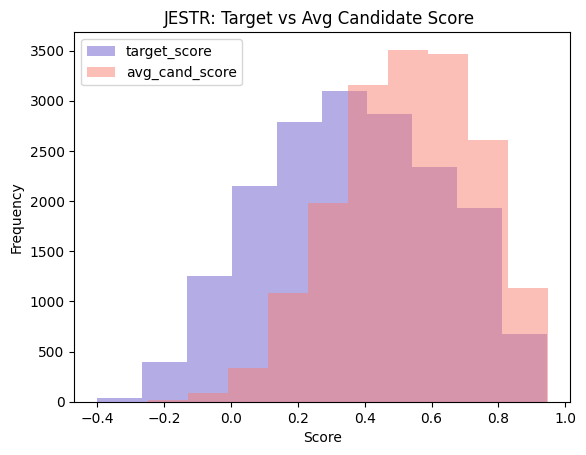

In [53]:
plt.hist(jestr_results['target_score'], color='slateblue', alpha=0.5, label= 'target_score')
plt.hist(jestr_results['best_cand_score'], color='salmon', alpha=0.5, label= 'avg_cand_score')
plt.title("JESTR: Target vs Avg Candidate Score ")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()

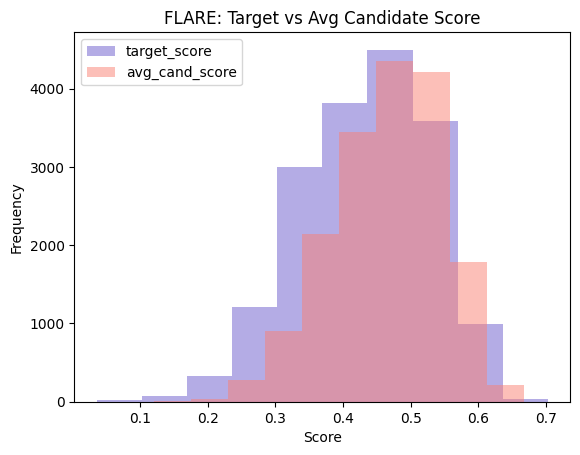

In [54]:
plt.hist(flare_results['target_score'], color='slateblue', alpha=0.5, label= 'target_score')
plt.hist(flare_results['best_cand_score'], color='salmon', alpha=0.5, label= 'avg_cand_score')
plt.title("FLARE: Target vs Avg Candidate Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()

Text(0.5, 1.0, 'FLARE: Target Score vs Rank (ρ=0.33)')

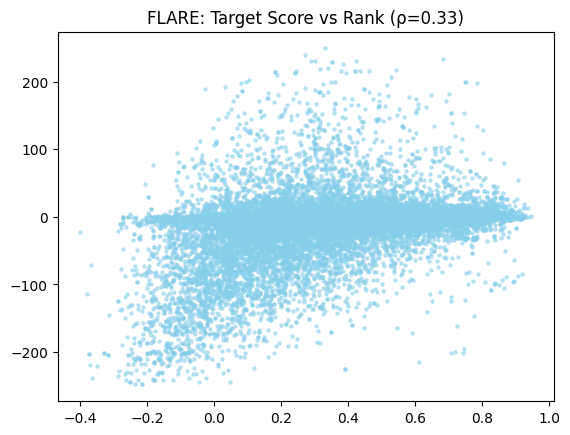

In [69]:
delta_rank = flare_results['rank'] - jestr_results['rank']
plt.scatter(jestr_results['target_score'], delta_rank, alpha=0.5, s=5, color='skyblue', label='FLARE')

# correlation
rho, p = spearmanr(jestr_results['target_score'], delta_rank)
plt.title(f"FLARE: Target Score vs Rank (ρ={rho:.2f})")

Text(0.5, 1.0, 'JESTR: Target Score vs Rank (ρ=-0.52)')

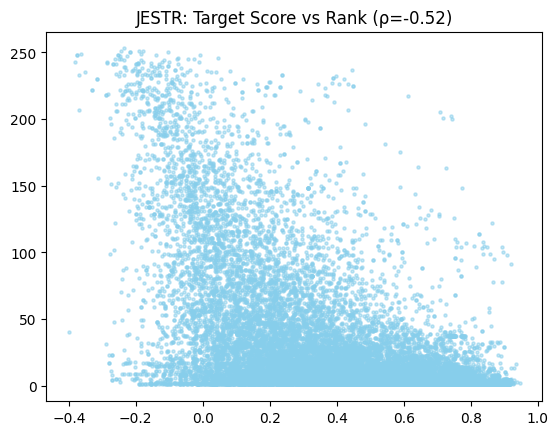

In [66]:
plt.scatter(jestr_results['target_score'], jestr_results['rank'], alpha=0.5, s=5, color='skyblue', label='JESTR')

# correlation
rho, p = spearmanr(jestr_results['target_score'], jestr_results['rank'])
plt.title(f"JESTR: Target Score vs Rank (ρ={rho:.2f})")